<img src="https://www.bestdesigns.co/uploads/inspiration_images/4350/990__1511457498_404_walmart.png" alt="WALMART LOGO" />

# Walmart : predict weekly sales

## Company's Description 📇

Walmart Inc. is an American multinational retail corporation that operates a chain of hypermarkets, discount department stores, and grocery stores from the United States, headquartered in Bentonville, Arkansas. The company was founded by Sam Walton in 1962.

## Project 🚧

Walmart's marketing service has asked you to build a machine learning model able to estimate the weekly sales in their stores, with the best precision possible on the predictions made. Such a model would help them understand better how the sales are influenced by economic indicators, and might be used to plan future marketing campaigns.

## Goals 🎯

The project can be divided into three steps:

- Part 1 : make an EDA and all the necessary preprocessings to prepare data for machine learning
- Part 2 : train a **linear regression model** (baseline)
- Part 3 : avoid overfitting by training a **regularized regression model**

## Scope of this project 🖼️

For this project, you'll work with a dataset that contains information about weekly sales achieved by different Walmart stores, and other variables such as the unemployment rate or the fuel price, that might be useful for predicting the amount of sales. The dataset has been taken from a Kaggle competition, but we made some changes compared to the original data. Please make sure that you're using **our** custom dataset (available on JULIE). 🤓

## Deliverable 📬

To complete this project, your team should: 

- Create some visualizations
- Train at least one **linear regression model** on the dataset, that predicts the amount of weekly sales as a function of the other variables
- Assess the performances of the model by using a metric that is relevant for regression problems
- Interpret the coefficients of the model to identify what features are important for the prediction
- Train at least one model with **regularization (Lasso or Ridge)** to reduce overfitting


## Helpers 🦮

To help you achieve this project, here are a few tips that should help you: 

### Part 1 : EDA and data preprocessing

Start your project by exploring your dataset : create figures, compute some statistics etc...

Then, you'll have to make some preprocessing on the dataset. You can follow the guidelines from the *preprocessing template*. There will also be some specific transformations to be planned on this dataset, for example on the *Date* column that can't be included as it is in the model. Below are some hints that might help you 🤓

 #### Preprocessing to be planned with pandas

 **Drop lines where target values are missing :**
 - Here, the target variable (Y) corresponds to the column *Weekly_Sales*. One can see above that there are some missing values in this column.
 - We never use imputation techniques on the target : it might create some bias in the predictions !
 - Then, we will just drop the lines in the dataset for which the value in *Weekly_Sales* is missing.
 
**Create usable features from the *Date* column :**
The *Date* column cannot be included as it is in the model. Either you can drop this column, or you will create new columns that contain the following numeric features : 
- *year*
- *month*
- *day*
- *day of week*

**Drop lines containing invalid values or outliers :**
In this project, will be considered as outliers all the numeric features that don't fall within the range : $[\bar{X} - 3\sigma, \bar{X} + 3\sigma]$. This concerns the columns : *Temperature*, *Fuel_price*, *CPI* and *Unemployment*
 


**Target variable/target (Y) that we will try to predict, to separate from the others** : *Weekly_Sales*

 **------------**

 #### Preprocessings to be planned with scikit-learn

 **Explanatory variables (X)**
We need to identify which columns contain categorical variables and which columns contain numerical variables, as they will be treated differently.

 - Categorical variables : Store, Holiday_Flag
 - Numerical variables : Temperature, Fuel_Price, CPI, Unemployment, Year, Month, Day, DayOfWeek

### Part 2 : Baseline model (linear regression)
Once you've trained a first model, don't forget to assess its performances on the train and test sets. Are you satisfied with the results ?
Besides, it would be interesting to analyze the values of the model's coefficients to know what features are important for the prediction. To do so, the `.coef_` attribute of scikit-learn's LinearRegression class might be useful. Please refer to the following link for more information 😉 https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

### Part 3 : Fight overfitting
In this last part, you'll have to train a **regularized linear regression model**. You'll find below some useful classes in scikit-learn's documentation :
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso

**Bonus question**

In regularized regression models, there's a hyperparameter called *the regularization strength* that can be fine-tuned to get the best generalized predictions on a given dataset. This fine-tuning can be done thanks to scikit-learn's GridSearchCV class : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Also, you'll find here some examples of how to use GridSearchCV together with Ridge or Lasso models : https://alfurka.github.io/2018-11-18-grid-search/

# Part 1 : EDA and data preprocessing

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Walmart_Store_sales.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


### Data Understanding

There are sales data available for 20 stores of Walmart in [Kaggle](https://www.kaggle.com/aditya6196/retail-analysis-with-walmart-data). This is the data that covers sales from 2010-02-05 to 2012-10-19. 

The data contains these features:
- Store - the store number
- Date - the week of sales
- Weekly_Sales - sales for the given store
- Holiday_Flag - whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week
- Temperature - Temperature on the day of sale
- Fuel_Price - Cost of fuel in the region
- CPI – Prevailing consumer price index
- Unemployment - Prevailing unemployment rate

In [3]:
# dropping rows with missing values in target
df = df.dropna(subset=['Weekly_Sales'])

# Processing date as proper datetime format and converting temperature from fahrenheit to celsius
df["Date"]=pd.to_datetime(df["Date"], dayfirst=True)
df = df.sort_values(by ='Date').reset_index(drop=True)
df['Temperature'] = round((df['Temperature'] -32)*5/9,2)


df.describe(include='all')

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,136.000000,118,1.360000e+02,125.000000,121.000000,124.000000,125.000000,122.000000
mean,10.014706,2011-04-23 04:28:28.474576384,1.249536e+06,0.072000,16.030083,3.316992,178.091144,7.665582
min,1.000000,2010-02-05 00:00:00,2.689290e+05,0.000000,-7.340000,2.514000,126.111903,5.143000
25%,4.000000,2010-07-30 00:00:00,6.050757e+05,0.000000,7.340000,2.838500,131.637000,6.690000
50%,10.000000,2011-04-29 00:00:00,1.261424e+06,0.000000,16.810000,3.451000,196.919506,7.477000
75%,15.250000,2011-12-31 18:00:00,1.806386e+06,0.000000,24.420000,3.724000,214.878556,8.150000
max,20.000000,2012-10-19 00:00:00,2.771397e+06,1.000000,33.140000,4.193000,226.968844,14.313000
std,6.124614,NaN,6.474630e+05,0.259528,10.285921,0.479540,40.243105,1.619428


In [4]:
# Dropping outliers : defined as 3 times above or below standard deviation in this project, for the following columns.
df['Temperature']=df['Temperature'].apply(lambda x: np.nan if (np.abs(x - df['Temperature'].mean()) / df['Temperature'].std() > 3) else x)
df['Fuel_Price']=df['Fuel_Price'].apply(lambda x: np.nan if (np.abs(x - df['Fuel_Price'].mean()) / df['Fuel_Price'].std() > 3) else x)
df['CPI']=df['CPI'].apply(lambda x: np.nan if (np.abs(x - df['CPI'].mean()) / df['CPI'].std() > 3) else x)
df['Unemployment']=df['Unemployment'].apply(lambda x: np.nan if (np.abs(x - df['Unemployment'].mean()) / df['Unemployment'].std() > 3) else x)

In [5]:
# dropping row if more than 2 features are missing in the same row
df = df.dropna(thresh=2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         136 non-null    float64       
 1   Date          118 non-null    datetime64[ns]
 2   Weekly_Sales  136 non-null    float64       
 3   Holiday_Flag  125 non-null    float64       
 4   Temperature   121 non-null    float64       
 5   Fuel_Price    124 non-null    float64       
 6   CPI           125 non-null    float64       
 7   Unemployment  117 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 8.6 KB


In [7]:
print("Missing data in %")
print(df.isna().sum()/len(df)*100)

Missing data in %
Store            0.000000
Date            13.235294
Weekly_Sales     0.000000
Holiday_Flag     8.088235
Temperature     11.029412
Fuel_Price       8.823529
CPI              8.088235
Unemployment    13.970588
dtype: float64


A signicant portion of data is missing, even after we dropped rows where there was no data for the target.

In [8]:
'''''choisir lors de l'utilisation de la fonction fillna() dans pandas :

    method="bfill" : Cela signifie "backward fill" (remplissage vers l'arrière) ou "propagation de la valeur suivante". Lorsqu'une valeur manquante est rencontrée, elle est remplie avec la valeur de la ligne suivante de la colonne. Cela peut être utile lorsque vous souhaitez propager les valeurs de la ligne suivante pour remplir les valeurs manquantes.

    value=<valeur> : Vous pouvez spécifier une valeur spécifique (non manquante) à utiliser pour remplir les valeurs manquantes. Par exemple, df['Unemployment'].fillna(value=0) remplirait les valeurs manquantes avec zéro.

    method="mean" : Cette méthode remplit les valeurs manquantes avec la moyenne des valeurs non manquantes de la colonne.

    method="median" : Cette méthode remplit les valeurs manquantes avec la médiane des valeurs non manquantes de la colonne.

    method="interpolate" : Cette méthode effectue une interpolation linéaire pour remplir les valeurs manquantes en utilisant une estimation basée sur les valeurs non manquantes voisines. Cela peut être utile lorsque vous avez une tendance linéaire dans vos données.'''

# Dealing with 
df['Date'].fillna(method="ffill", inplace=True)
df['Holiday_Flag'].fillna(method="ffill", inplace=True)
df['Fuel_Price'].fillna(method="ffill", inplace=True)
df['CPI'].fillna(method="ffill", inplace=True)
df['Unemployment'].fillna(method="ffill", inplace=True)
df['Temperature'].fillna(method="ffill", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         136 non-null    float64       
 1   Date          136 non-null    datetime64[ns]
 2   Weekly_Sales  136 non-null    float64       
 3   Holiday_Flag  136 non-null    float64       
 4   Temperature   136 non-null    float64       
 5   Fuel_Price    136 non-null    float64       
 6   CPI           136 non-null    float64       
 7   Unemployment  136 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 8.6 KB


In [9]:
# checking for missing values
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

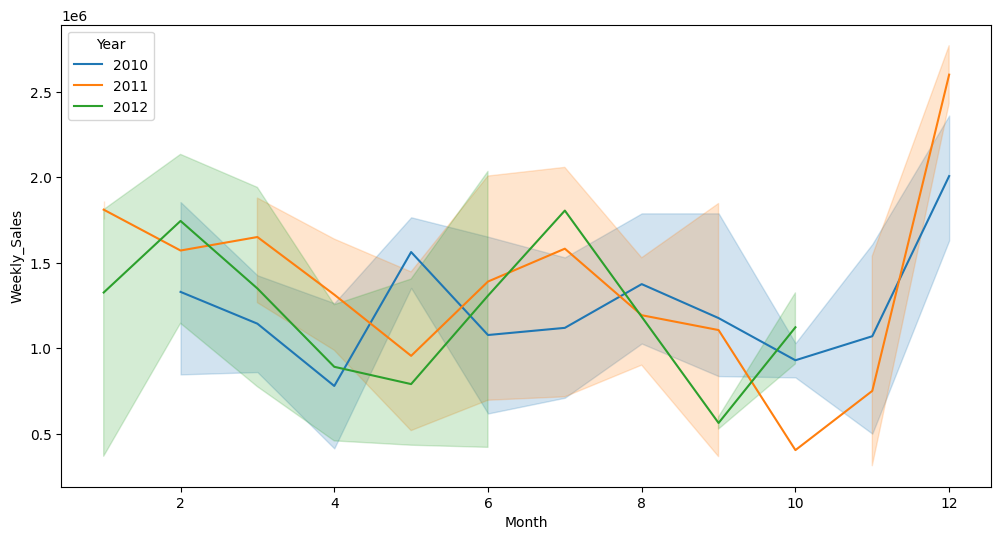

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year,Day_of_Week
0,3.0,2010-02-05,461622.22,0.0,7.62,2.572,214.424881,7.368,5,2,2010,4
1,1.0,2010-02-12,1641957.44,1.0,3.62,2.548,211.242170,8.106,12,2,2010,4
2,8.0,2010-02-12,994801.40,1.0,0.74,2.548,214.621419,6.299,12,2,2010,4
3,15.0,2010-02-19,660838.75,0.0,0.74,2.909,131.637000,6.299,19,2,2010,4
4,2.0,2010-02-19,2124451.54,0.0,4.27,2.514,210.945160,6.299,19,2,2010,4


In [10]:
# Splitting Date and create new columns (Day, Month, and Year)
df["Day"]= pd.DatetimeIndex(df['Date']).day
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Day_of_Week'] = df['Date'].dt.day_of_week

plt.figure(figsize=(12,6))
sns.lineplot(data=df,x='Month',y='Weekly_Sales',hue='Year',palette='tab10')
plt.show()

df.head()

## Which store has minimum and maximum sales?

<class 'numpy.float64'>


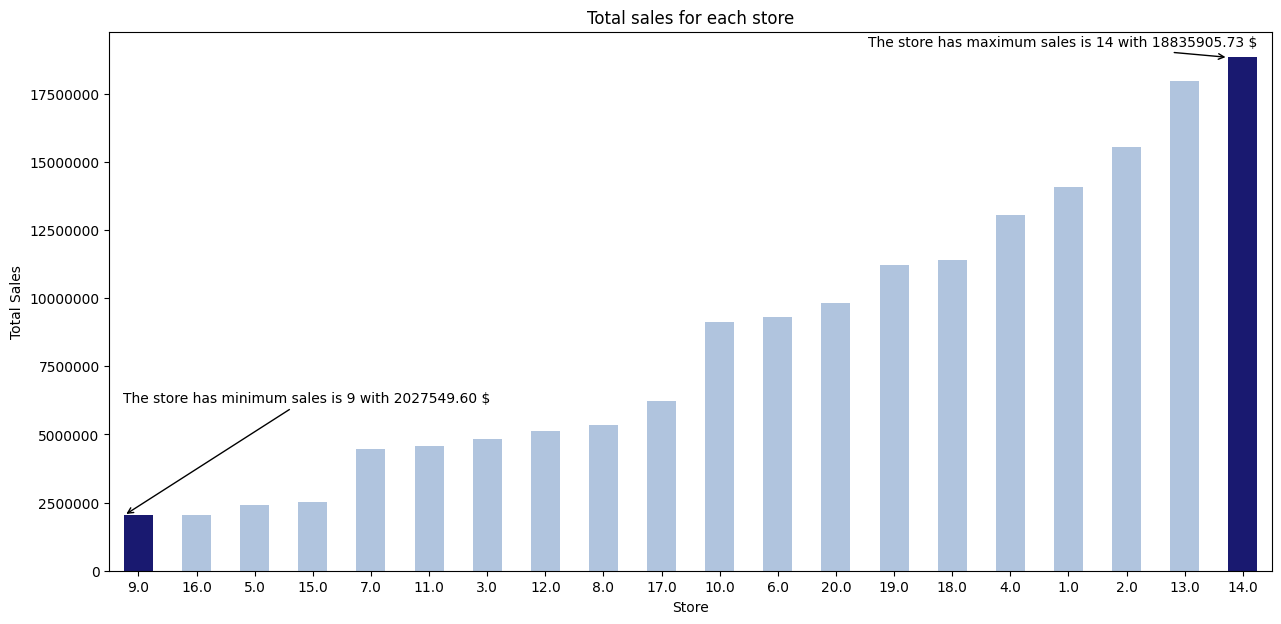

In [11]:
plt.figure(figsize=(15,7))

# Sum Weekly_Sales for each store, then sortded by total sales
total_sales_for_each_store = df.groupby('Store')['Weekly_Sales'].sum().sort_values() 
total_sales_for_each_store_array = np.array(total_sales_for_each_store) # convert to array

# Assigning a specific color for the stores have the lowest and highest sales
clrs = ['lightsteelblue' if ((x < max(total_sales_for_each_store_array)) and (x > min(total_sales_for_each_store_array))) else 'midnightblue' for x in total_sales_for_each_store_array]


ax = total_sales_for_each_store.plot(kind='bar',color=clrs);

# store have minimum sales
p = ax.patches[0]
print(type(p.get_height()))
ax.annotate("The store has minimum sales is 9 with {0:.2f} $".format((p.get_height())), xy=(p.get_x(), p.get_height()), xycoords='data',
            xytext=(0.17, 0.32), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            horizontalalignment='center', verticalalignment='center')


# store have maximum sales 
p = ax.patches[19]
ax.annotate("The store has maximum sales is 14 with {0:.2f} $".format((p.get_height())), xy=(p.get_x(), p.get_height()), xycoords='data',
            xytext=(0.82, 0.98), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            horizontalalignment='center', verticalalignment='center')


# plot properties
plt.xticks(rotation=0)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Total sales for each store')
plt.xlabel('Store')
plt.ylabel('Total Sales');

## There is a clear difference in sales between stores. This will likely be useful in our model.

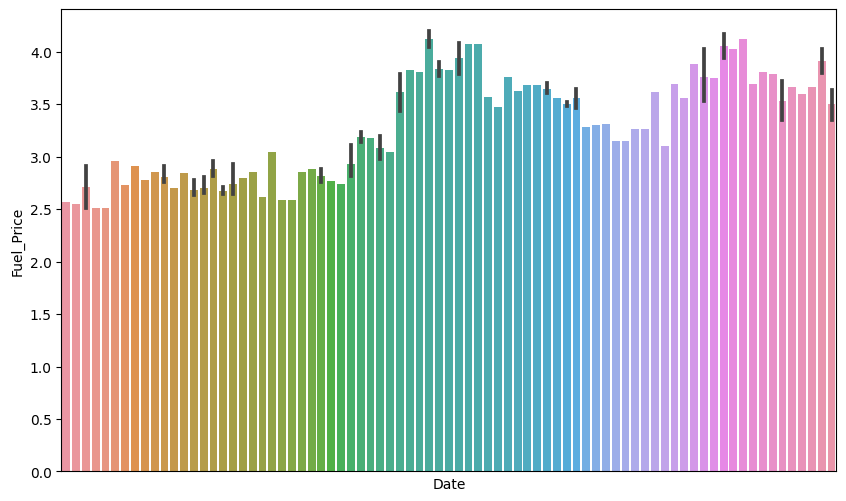

In [12]:
plt.figure(figsize=(10,6))
sns.barplot(y=df['Fuel_Price'],x=df['Date'])
plt.xticks([])
plt.show()

In [13]:
print(f"The price for the gallon of gas went from $ {round(df['Fuel_Price'].min(),2)} to $ {round(df['Fuel_Price'].max(),2)}, between {int(df['Year'].min())} and {int(df['Year'].max())}.")
print(f"The price of gas peaked {df[df['Fuel_Price']== df['Fuel_Price'].max()].values[0,1]}")

The price for the gallon of gas went from $ 2.51 to $ 4.19, between 2010 and 2012.
The price of gas peaked 2011-05-06 00:00:00


In [14]:
df['Holiday_Flag'] = df['Holiday_Flag'].map({1:'Yes',0:'No'})
print(f"Weekly sales around holidays are $ {round(df[df['Holiday_Flag'] == 'Yes']['Weekly_Sales'].mean(),2)}, which is above the average of \
$ {round(df['Weekly_Sales'].mean(),2)}, though the difference is well below standard deviation of $ {round(df['Weekly_Sales'].std(),2)}.")

Weekly sales around holidays are $ 1371152.9, which is above the average of $ 1249535.83, though the difference is well below standard deviation of $ 647463.04.


### Spikes in sales are not centered around specific holidays : there may be other parameters or customers start buying well before or after the actual date.

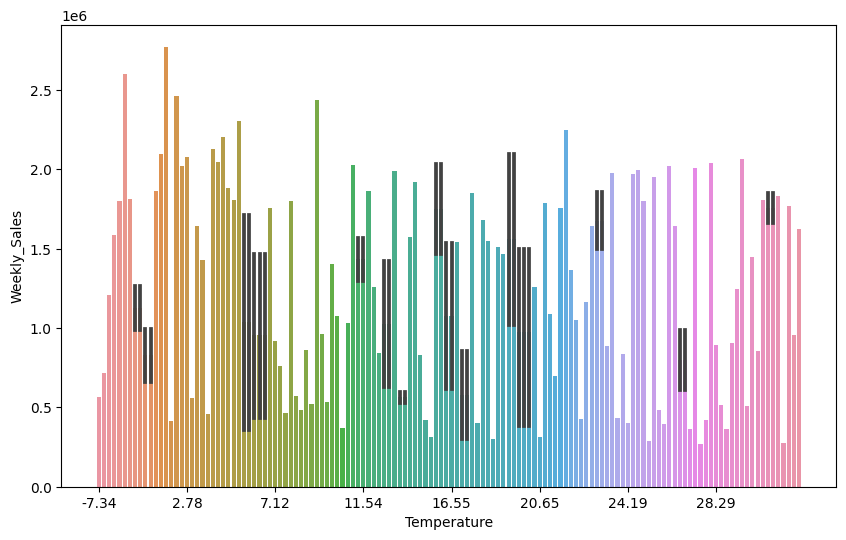

In [15]:
plt.figure(figsize=(10,6))
sns.barplot(y=df['Weekly_Sales'],x=df['Temperature'],order=df['Temperature'].sort_values())
plt.locator_params(axis='both', nbins=8)
plt.show()

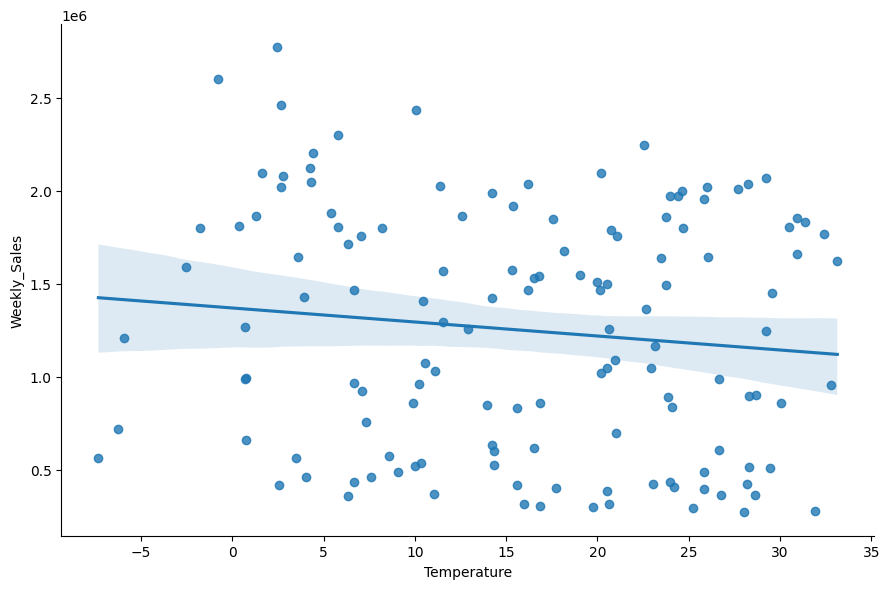

In [16]:
sns.lmplot(data=df,y='Weekly_Sales',x='Temperature',height=6,aspect=1.5)
plt.show()

### Temperature is weakly connected with sales, with a bit more at lower temperatures

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         136 non-null    float64       
 1   Date          136 non-null    datetime64[ns]
 2   Weekly_Sales  136 non-null    float64       
 3   Holiday_Flag  136 non-null    object        
 4   Temperature   136 non-null    float64       
 5   Fuel_Price    136 non-null    float64       
 6   CPI           136 non-null    float64       
 7   Unemployment  136 non-null    float64       
 8   Day           136 non-null    int32         
 9   Month         136 non-null    int32         
 10  Year          136 non-null    int32         
 11  Day_of_Week   136 non-null    int32         
dtypes: datetime64[ns](1), float64(6), int32(4), object(1)
memory usage: 10.8+ KB


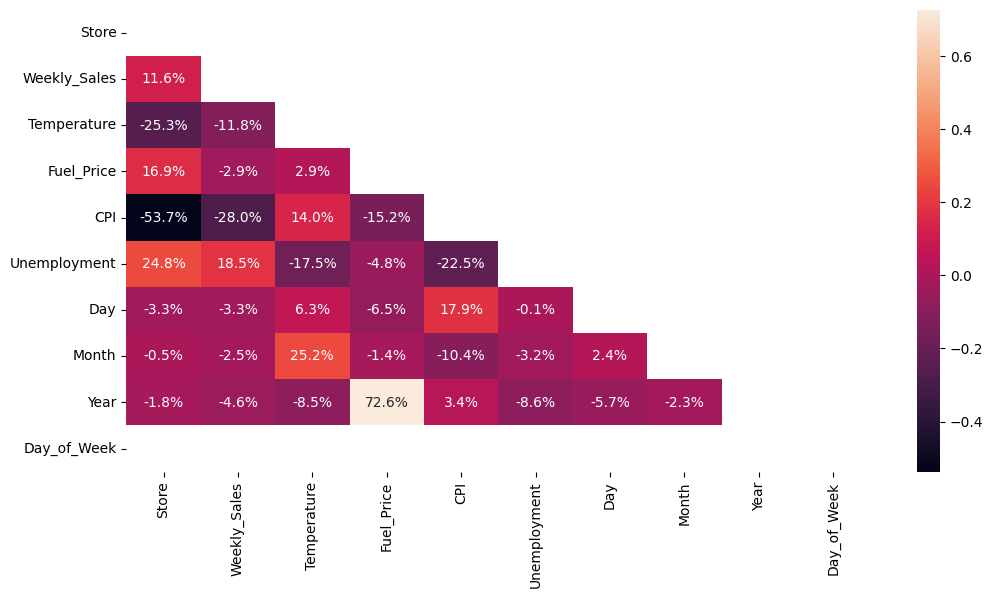

In [18]:
col=['Store','Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Day', 'Month', 'Year', 'Day_of_Week']
corr = df[col].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = 1

plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, mask=mask, fmt = '.1%')
plt.show()

Consumer price index may be the best lead we have in numerical features, but will probably be much less significant than stores.

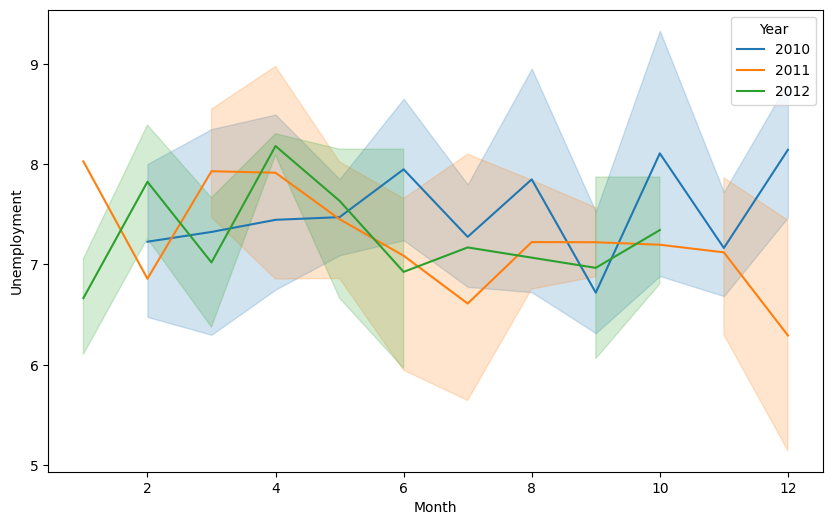

In [19]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df,x='Month',y='Unemployment',hue='Year',palette='tab10')
plt.show()

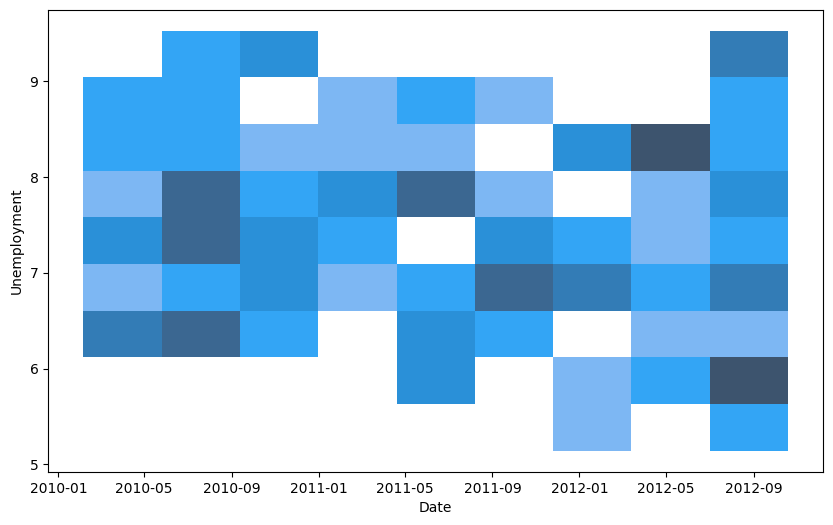

In [20]:
plt.figure(figsize=(10,6))
sns.histplot(data=df,x='Date',y='Unemployment')
plt.show()

Unemployment surged in end of 2010 and first half of 2011/2012 but has gone down since and the trend is still downward.

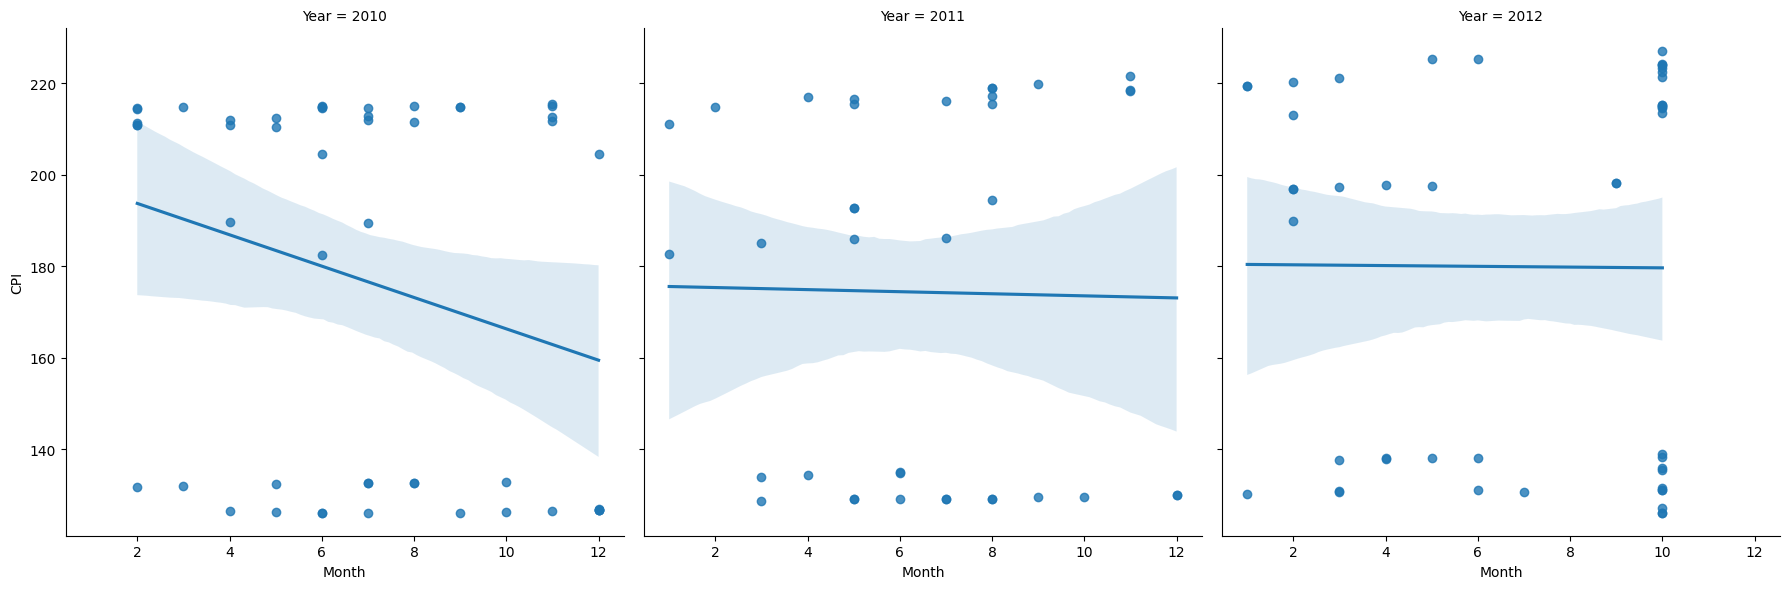

In [21]:
sns.lmplot(data=df, x="Month", y="CPI",col='Year',height=6)
plt.show()

CPI tanked somewhat in 2010 but is globally increasing in 2011 and 2012, despite frequent ups and downs.

# Part 2 : Baseline model (linear regression)

In [22]:
X = df.drop(['Date','Weekly_Sales'],axis=1)
y = df['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [23]:
numeric_features = ['Temperature', 'Fuel_Price','CPI', 'Unemployment'] 
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()), 
    ('scaler', StandardScaler())
])

# Stores are numbers but nominal data, it is not a ranking
categorical_features = ['Store','Holiday_Flag','Year','Month','Day','Day_of_Week'] 
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first',handle_unknown='ignore')) 
    ])

preprocessor = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
    ])

In [24]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

/home/kamila/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Nothing special about encoding numerical & categorical features, but some imputing was necessary to deal with missing values.<br>
Time to implement our baseline model.

In [25]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_train_pred = lin_reg.predict(X_train)
Y_test_pred = lin_reg.predict(X_test)

print("r2-score on train set : ", r2_score(y_train, y_train_pred))
print("Standard deviation on train set :", cross_val_score(lin_reg, X_train, y_train, cv=10, scoring='r2').std())
print("r2-score on test set : ", r2_score(y_test, Y_test_pred))

r2-score on train set :  0.9910289451611071
Standard deviation on train set : 0.021804979970850836
r2-score on test set :  0.9228312635401341


Our model gives decent results but is massively overfitting !

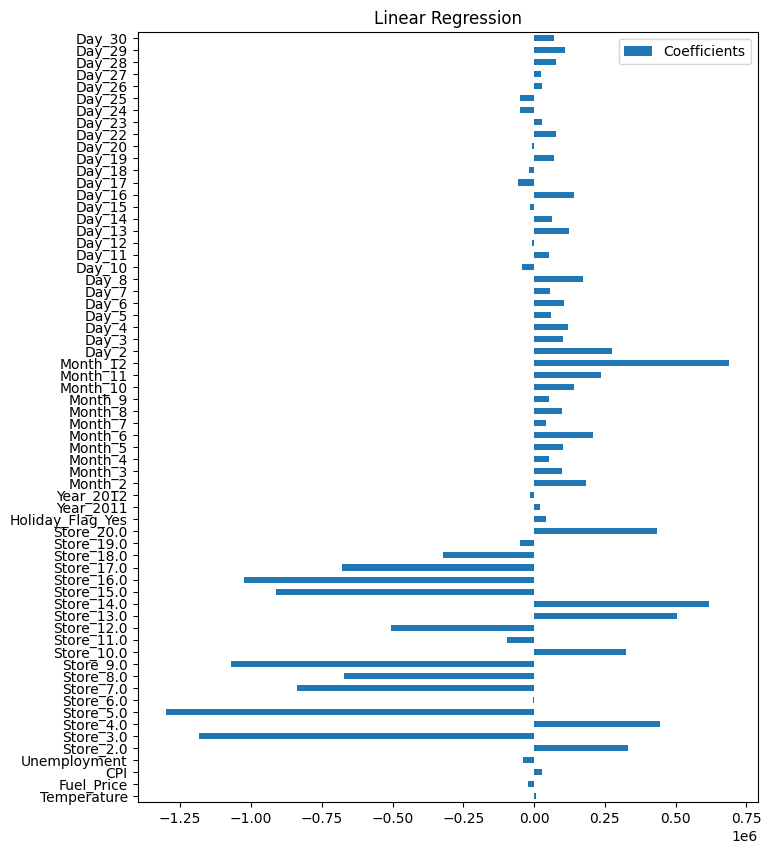

In [26]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())

coefs = pd.DataFrame(
   lin_reg.coef_,
   columns=['Coefficients'], index=col_names
)

coefs.plot(kind='barh', figsize=(8, 10))
plt.title('Linear Regression')
plt.show()

As expected, stores are the most important features for the model.

# Part 3 : Fight overfitting

In [27]:
model = Ridge()
params = {'alpha':[0.01, 0.02, 0.05, 0.1, 0.5, 1, 10]}

gridsearch = GridSearchCV(model, param_grid = params, cv = 10,scoring='r2') 
gridsearch.fit(X_train, y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Best hyperparameters :  {'alpha': 0.1}
Best validation accuracy :  0.9258862830867974


In [28]:
model = Lasso(max_iter=2000)
params = {'alpha':[0.1, 1, 10,100,500,1000]}

gridsearch = GridSearchCV(model, param_grid = params, cv = 10,scoring='r2') 
gridsearch.fit(X_train, y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Best hyperparameters :  {'alpha': 1000}
Best validation accuracy :  0.949137687331018


In [29]:
lasso = Lasso(alpha=500)
lasso.fit(X_train, y_train)

y_train_pred = lasso.predict(X_train)
Y_test_pred = lasso.predict(X_test)

print("r2-score on train set : ", r2_score(y_train, y_train_pred))
print("Standard deviation on train set :", cross_val_score(lasso, X_train, y_train, cv=10, scoring='r2').std())
print("r2-score on test set : ", r2_score(y_test, Y_test_pred))

r2-score on train set :  0.9892151796798776
Standard deviation on train set : 0.01528955497382496
r2-score on test set :  0.9284011828007521


After trying out the best parameters for Lasso and Ridge, Lasso provided much better r2 score for the test set with less overfitting, compared to the first attempt at linear regression.<br>
To improve further, we could try out other models... And ideally feed more data.